# Global and Regional PDP

This tutorial is an introduction to global and regional PDP; it demonstrates how to use `Effector` to explain a black box function, utilizing two synthetic datasets—one with uncorrelated features and the other with correlated features.

In [1]:
import numpy as np
import effector

## Simulation example

### Data Generating Distribution

We will generate $N=1000$ examples with $D=3$ features. In the uncorrelated setting, all variables are uniformly distributed, i.e., $x_i \sim \mathcal{U}(-1,1)$. In the correlated setting, we keep the distributional assumptions for $x_1$ and $x_2$ but define $x_3$ such that it is identical to $x_3$ by: $x_3 = x_1$.

In [2]:
def generate_dataset_uncorrelated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = np.random.uniform(-1, 1, size=N)
    return np.stack((x1, x2, x3), axis=-1)

def generate_dataset_correlated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = x1
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset for the uncorrelated and correlated setting
N = 10_000
X_uncor = generate_dataset_uncorrelated(N)
X_cor = generate_dataset_correlated(N)

### Black-box function

We will use the following linear model with a subgroup-specific interaction term:
 $$ y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq0} + x_3$$ 

The presence of interaction terms ($3x_1I_{x_3>0}$, $3x_1I_{x_3\leq0}$) makes it impossible to define a solid ground truth effect. However, under some mild assumptions, we can agree tha

### Ground truth effect (uncorrelated setting)

In the uncorrelated scenario, the effects are as follows:

- For the feature $x_1$, the global effect will be $3x_1$ half of the time (when $I_{x_3>0}$) and $-3x_1$ the other half (when $3x_1I_{x_3\leq0}$). This results in a zero global effect with high heterogeneity. The regional effect should be divided into two subregions: $x_3>0$ and $x_3 \leq 0$, leading to two regional effects with zero heterogeneity: $3x_1$ and $-3x_1$.

- For feature $x_2$, the global effect is zero, without heterogeneity.

- For feature $x_3$, there is a global effect of $x_3$ without heterogeneity due to the last term. Depending on the feature effect method, the terms $3x_1I_{x_3>0}$ and $-3x_1I_{x_3\leq0}$ may also introduce some effect.

### Ground truth effect (correlated setting)

In the correlated scenario, where $x_3 = x_1$, the effects are as follows:

- For the feature $x_1$, the global effect is $3x_1I_{x_1>0} - 3x_1I_{x_1\leq 0}$ without heterogeneity. This is because when $x_1>0$, $x_3>0$, so only the term $3x_1$ is active. Similarly, when $x_1\leq 0$, $x_3 \leq 0$, making the term $-3x_1$ active.
- For the feature $x_2$, the global effect is zero, without heterogeneity.
- For the feature $x_3$, the global effect is $x_3$.

In [3]:
def model(x):
    f = np.where(x[:,2] > 0, 3*x[:,0] + x[:,2], -3*x[:,0] + x[:,2])
    return f

def model_jac(x):
    dy_dx = np.zeros_like(x)
    
    ind1 = x[:, 2] > 0
    ind2 = x[:, 2] <= 0
    
    dy_dx[ind1, 0] = 3
    dy_dx[ind2, 0] = -3
    dy_dx[:, 2] = 1
    return dy_dx


In [4]:
Y_cor = model(X_cor)
Y_uncor = model(X_uncor)      

## PDP definition

The PDP is defined as **_the average of the model's output over the entire dataset, while varying the feature of interest._**:

$$ \text{PDP}(x_s) = \mathbb{E}_{x_c}[f(x_s, x_c)] $$ 

and is approximated using the training data: 

$$ \hat{\text{PDP}}(x_s) = \frac{1}{N} \sum_{j=1}^N f(x_s, x^{(i)}_c) =  \frac{1}{N} \sum_{j=1}^N ICE^j(x_s)$$

The PDP is the average of the underlying ICE curves (local effects). An ICE curve is **the model's output for a single instance while varying the feature of interest**. The heterogeneity is determined by how much the ICE curves differ from the PDP plot.

## Uncorrelated setting

### Global PDP

In [5]:
regional_rhale = effector.RegionalPDP(data=X_uncor, model=model, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
regional_rhale.fit(heter_pcg_drop_thres=0.3, nof_candidate_splits_for_numerical=11, centering=True)
effector.binning_methods.DynamicProgramming()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.98it/s]


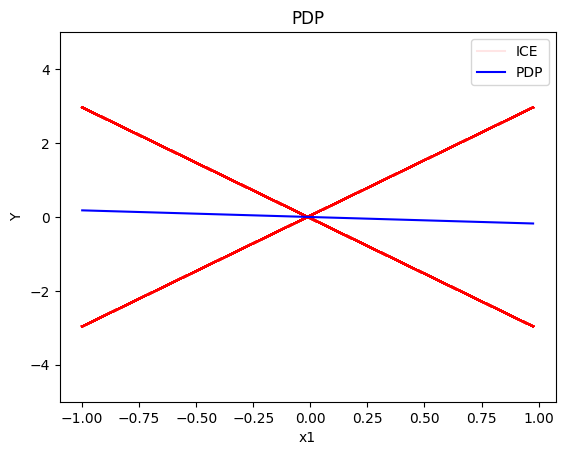

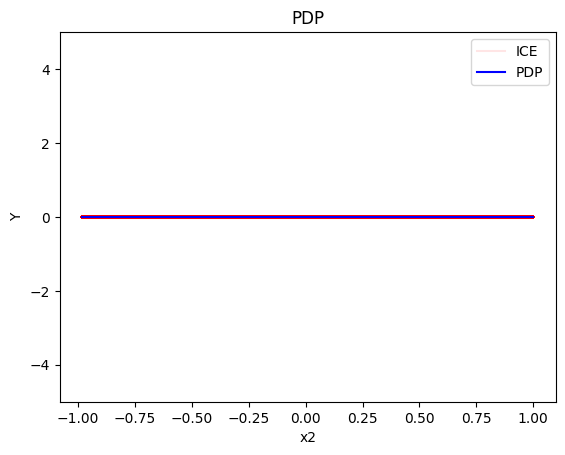

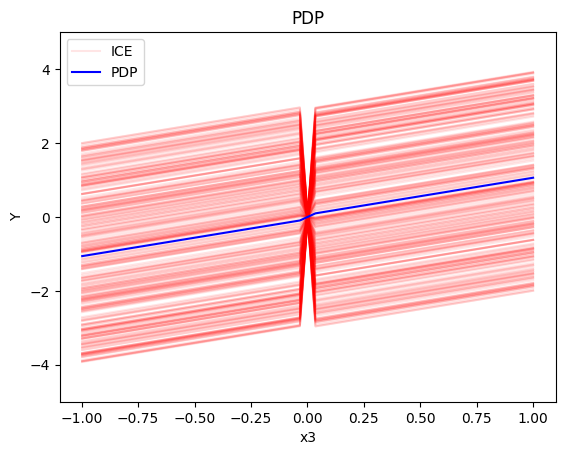

In [6]:
pdp = effector.PDP(data=X_uncor, model=model, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

### Conclusion

* the global effect of $x_1$ is $0$ with some heterogeneity due to the interaction with $x_1$; the heterogeneity is expressed with two opposite lines; $-3x_1$ and $3x_1$
* the global effect of $x_2$ is $0$ without heterogeneity
* the global effect of $x_3$ is $x_3$ with some heterogeneity due to the interaction with $x_1$. The heterogeneity is expressed with a discontinuity around $x_3=0$; either going from a negative offset to a positive or vice-versa.


### Regional PDP

Regional PDP will search for explanations that minimize the interaction-related heterogeneity.

In [7]:
regional_pdp = effector.RegionalPDP(data=X_uncor, model=model, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
regional_pdp.fit(features="all", heter_pcg_drop_thres=0.3, nof_candidate_splits_for_numerical=11, centering=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 23.29it/s]


In [8]:
regional_pdp.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 3.98 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.0, heter: 0.09 || nof_instances:   535 || weight: 0.54
        Node id: 2, name: x1 | x3  > 0.0, heter: 0.09 || nof_instances:   465 || weight: 0.47
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 3.98
        Level 1, heter: 0.09 || heter drop: 3.89 (97.82%)


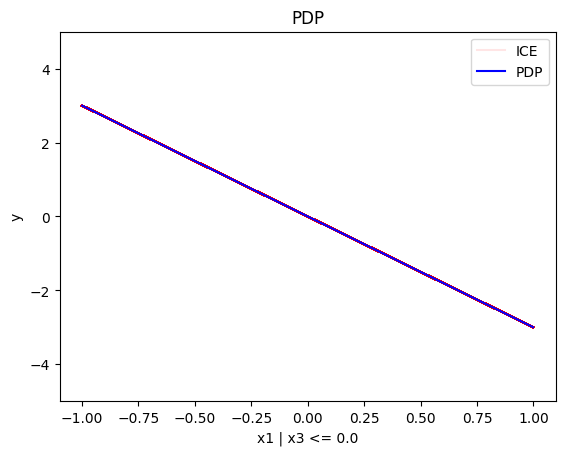

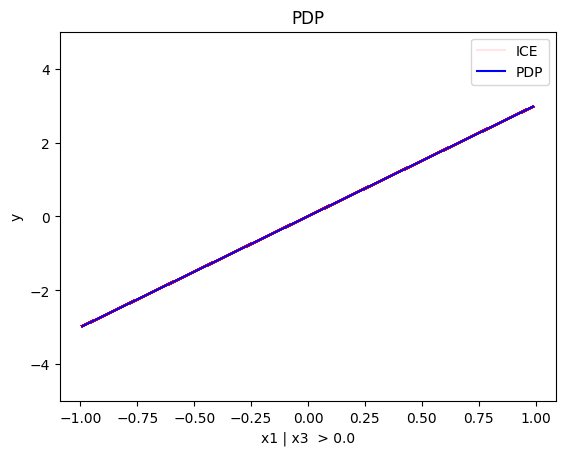

In [9]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

In [10]:
regional_pdp.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 3.21 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 3.21


In [11]:
regional_pdp.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 2.91 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x3 | x1 <= -0.0, heter: 0.72 || nof_instances:   513 || weight: 0.51
        Node id: 2, name: x3 | x1  > -0.0, heter: 0.80 || nof_instances:   487 || weight: 0.49
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 2.91
        Level 1, heter: 0.76 || heter drop: 2.15 (73.91%)


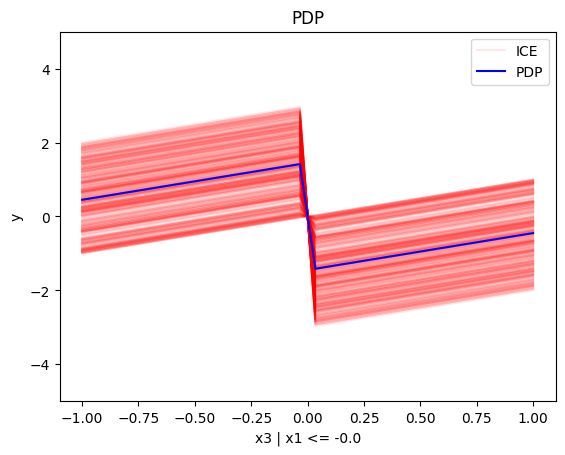

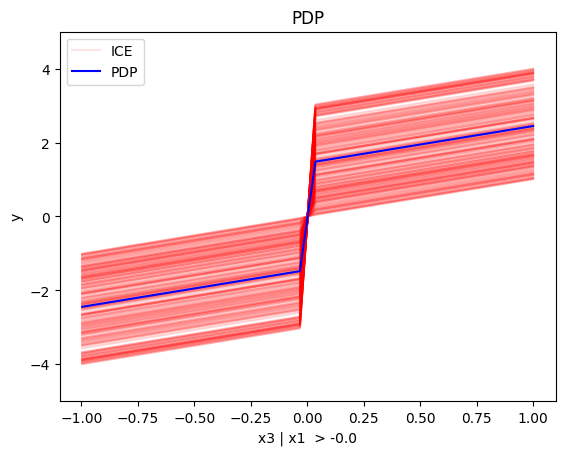

In [12]:
regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

### Conclusion

* For $x_1$, the algorithm finds two regions, one for $x_3 \leq 0$ and one for $x_3 > 0$
  * when $x_3>0$ the effect is $3x_1$ without heterogeneity
  * when $x_3 \leq 0$, the effect is $-3x_1$ without heterogeneity
* For $x_2$ the algorithm does not find any subregion 
* For $x_3$, the algorithm finds two regions, there is a change in the offset:
  * when $x_1<0$ the line is $x_3 + c^i$ in the first half and $x_3 - c^i$ later, where $c^i$ is $3x_1^i$. The jump at $x_1=0$ is therefore $-2c^i$
  * when $x_1>0$ the line is $x_3 - c^i$ in the first half and $x_3 + c^i$ later, where $c^i$ is $3x_1^i$. The jump at $x_1=0$ is therefore $2c^i$


## Correlated setting

### Global PDP

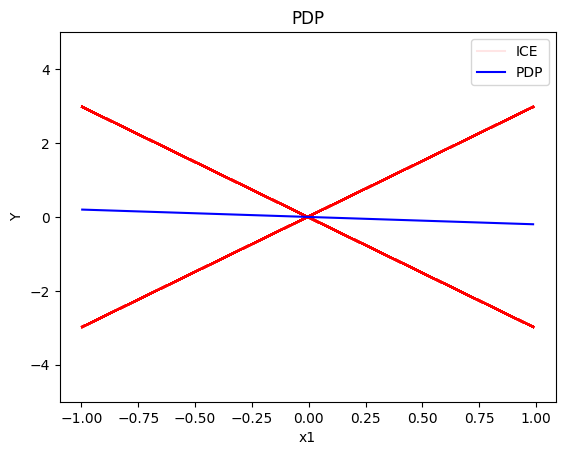

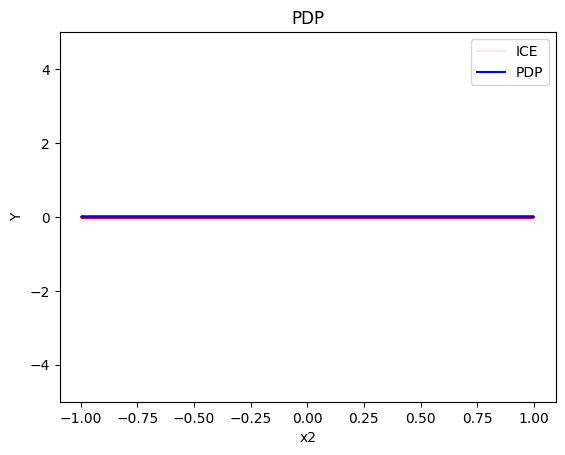

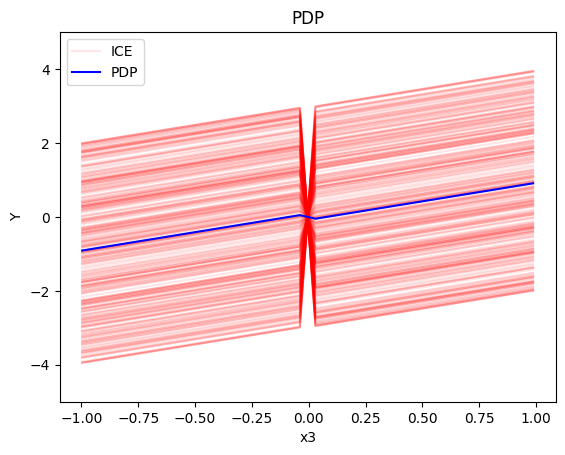

In [13]:
pdp = effector.PDP(data=X_cor, model=model, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

### Regional-PDP

In [14]:
regional_pdp = effector.RegionalPDP(data=X_cor, model=model, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
regional_pdp.fit(features="all", heter_pcg_drop_thres=0.4, nof_candidate_splits_for_numerical=11)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 49.34it/s]


In [15]:
regional_pdp.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 3.99 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.0, heter: 0.10 || nof_instances:   497 || weight: 0.50
        Node id: 2, name: x1 | x3  > 0.0, heter: 0.08 || nof_instances:   503 || weight: 0.50
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 3.99
        Level 1, heter: 0.09 || heter drop: 3.90 (97.66%)


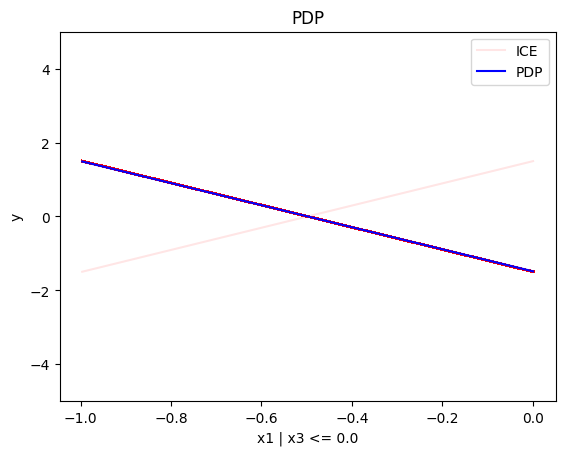

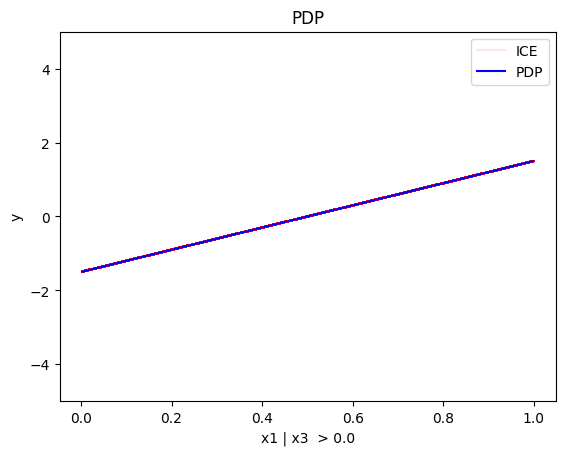

In [16]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

In [17]:
regional_pdp.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 1.08 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x2 | x1 <= 0.55, heter: 0.34 || nof_instances:   765 || weight: 0.77
        Node id: 2, name: x2 | x1  > 0.55, heter: 0.27 || nof_instances:   235 || weight: 0.23
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 1.08
        Level 1, heter: 0.32 || heter drop: 0.76 (70.18%)


In [18]:
regional_pdp.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 3.03 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x3 | x1 <= 0.0, heter: 0.76 || nof_instances:   497 || weight: 0.50
        Node id: 2, name: x3 | x1  > 0.0, heter: 0.75 || nof_instances:   503 || weight: 0.50
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 3.03
        Level 1, heter: 0.75 || heter drop: 2.28 (75.17%)


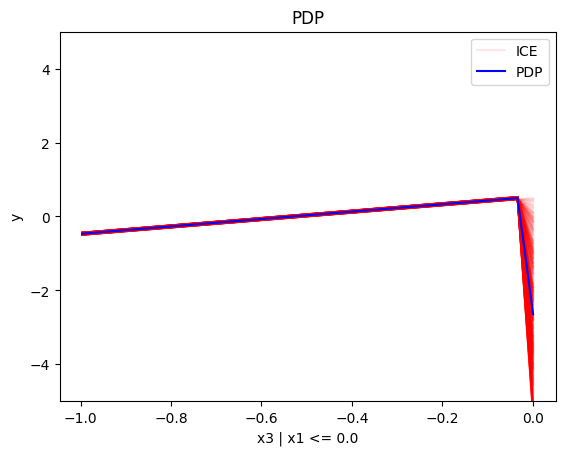

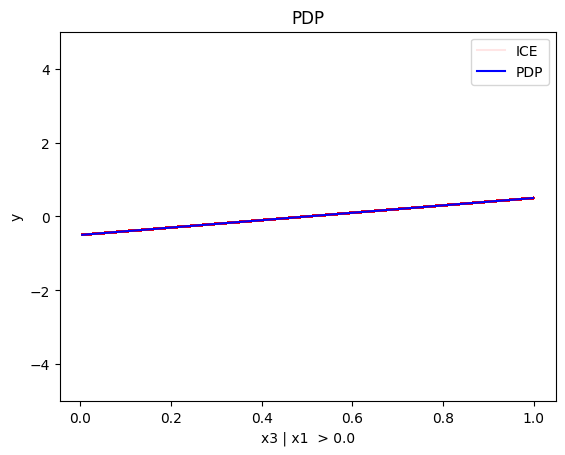

In [19]:
regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

### Conclusion

PDP assumes feature independence, therefore, it is *not* a good explanation method for the correlated case.
Due to this fact, the global and regional effects are identical to the uncorrelated case.